# HW5 : Kernel Methods for Regression

Official instructions:

https://www.cs.tufts.edu/cs/135/2023f/hw5.html

This is the starter code notebook.

## IMPORTANT: 

Make sure that you have implemented the kernel functions in `linear_kernel.py` and `sqexp_kernel.py`


## Import relevant packages

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import time
import importlib
import itertools

In [ ]:
import sklearn.linear_model
import sklearn.pipeline
import sklearn.metrics

In [ ]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Load Training set data for the 'ByYear' split

In [ ]:
DATA_DIR = os.path.join("data_melbourne_daily_min_temp/") #TODO: fix it to your local file structure

In [ ]:
data_trByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_train_ByYear.csv'))

In [ ]:
# Inspect the first few entries
data_trByYear_df.head()

,date,years_since_19850101,temp_deg_C
0,1981-01-01,-4.002740,20.7
1,1981-01-02,-4.000000,17.9
2,1981-01-03,-3.997260,18.8
3,1981-01-04,-3.994521,14.6
4,1981-01-05,-3.991781,15.8


In [ ]:
# Inspect the last few entries
data_trByYear_df.tail()

,date,years_since_19850101,temp_deg_C
2185,1986-12-27,1.986301,14.6
2186,1986-12-28,1.989041,14.2
2187,1986-12-29,1.991781,13.2
2188,1986-12-30,1.994521,11.7
2189,1986-12-31,1.997260,17.2


In [ ]:
# Read relevant columns into numpy arrays for x and y

x_trByYear_N1 = data_trByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_trByYear_N = data_trByYear_df['temp_deg_C'].values[:].copy()

print("Training data (ByYear split strategy)")
print("x_trByYear_N1.shape: %s" % str(x_trByYear_N1.shape))
print("y_trByYear_N.shape : %s" % str(y_trByYear_N.shape))
print("mean(y_trByYear_N) : %.3f" % np.mean(y_trByYear_N))

Training data (ByYear split strategy)
x_trByYear_N1.shape: (2190, 1)
y_trByYear_N.shape : (2190,)
mean(y_trByYear_N) : 11.003


# Load Validation set data for the 'ByYear' split

In [ ]:
data_vaByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_valid_ByYear.csv'))

data_vaByYear_df.head()

,date,years_since_19850101,temp_deg_C
0,1987-01-01,2.000000,12.3
1,1987-01-02,2.002740,13.8
2,1987-01-03,2.005479,15.3
3,1987-01-04,2.008219,15.6
4,1987-01-05,2.010959,16.2


In [ ]:
x_vaByYear_T1 = data_vaByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_vaByYear_T = data_vaByYear_df['temp_deg_C'].values[:].copy()

print("Validation data (ByYear split strategy)")
print("x_vaByYear_T1.shape: %s" % str(x_vaByYear_T1.shape))
print("y_vaByYear_T.shape : %s" % str(y_vaByYear_T.shape))
print("mean(y_vaByYear_T) : %.3f" % np.mean(y_vaByYear_T))

Validation data (ByYear split strategy)
x_vaByYear_T1.shape: (730, 1)
y_vaByYear_T.shape : (730,)
mean(y_vaByYear_T) : 11.413


# Plot both training and validation sets

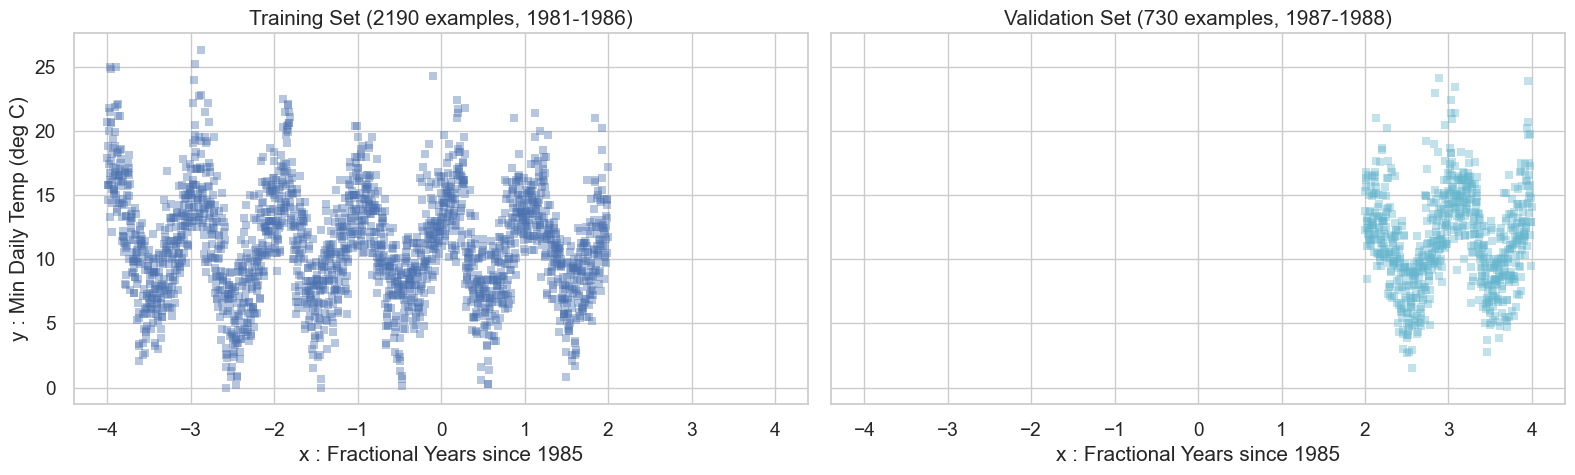

In [ ]:
fig, axgrid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,5))

axgrid[0].plot(x_trByYear_N1, y_trByYear_N, 'bs', alpha=0.4)
axgrid[0].set_xlabel('x : Fractional Years since 1985');
axgrid[0].set_title('Training Set (%d examples, %s-%s)' % (
    y_trByYear_N.size,
    pd.to_datetime(data_trByYear_df['date'].values[0]).year,
    pd.to_datetime(data_trByYear_df['date'].values[-1]).year))

axgrid[1].plot(x_vaByYear_T1, y_vaByYear_T, 'cs', alpha=0.4)
axgrid[1].set_xlabel('x : Fractional Years since 1985');
axgrid[1].set_title('Validation Set (%d examples, %s-%s)' % (
    y_vaByYear_T.size,
    pd.to_datetime(data_vaByYear_df['date'].values[0]).year,
    pd.to_datetime(data_vaByYear_df['date'].values[-1]).year))

axgrid[0].set_ylabel("y : Min Daily Temp (deg C)");
plt.tight_layout();

In [ ]:
# Make a placeholder for the kernels to be used
def identity_kernel(x_QF, x_train_NF=None, length_scale=None, period=None):
    return x_QF

# Prepare to use sklearn splitter tools for hyperparameter search

### Prep the ByYear splitter

In [ ]:
x_all_ByYear_L1 = np.vstack([x_trByYear_N1, x_vaByYear_T1])
y_all_ByYear_L = np.hstack([y_trByYear_N, y_vaByYear_T])

In [ ]:
# Create splitter object using Predefined Split
my_ByYear_splitter = sklearn.model_selection.PredefinedSplit(np.hstack([
    -1 * np.ones(y_trByYear_N.size), # -1 means never include this example in any 'test' split for grid search
    0  * np.ones(y_vaByYear_T.size), #  0 means include in the first test split (we count starting at 0 in python)
    ]))

# Define utility function to make pretty plots of predictions for each model

In [ ]:
def plot_data_and_predictions(model, model_legend_text='INSERT YOUR TEXT HERE'):
    plt.plot(x_trByYear_N1, y_trByYear_N, 'bs', alpha=0.4, label='train data');
    plt.plot(x_vaByYear_T1, y_vaByYear_T, 'cs', alpha=0.4, label='valid data');

    x_test_2 = [x_vaByYear_T1.min() + 2, x_vaByYear_T1.max() + 2]
    plt.fill_between(x_test_2, 0, 30, color='y', alpha=0.2, label='test period')

    L = 101
    xgrid_L1 = np.linspace(-5, 6, L).reshape((L,1))
    plt.plot(xgrid_L1, model.predict(xgrid_L1), 'r-', linewidth=3, label=model_legend_text);

    plt.ylim([0, 26]);
    plt.xlabel('Fractional Years since 1985');
    plt.ylabel("Min Daily Temp (deg C)");
    plt.legend(bbox_to_anchor=(1.0, 0.5));



# Problem 4: Linear Kernel Regression Baseline



### Load kernel function from your completed `linear_kernel.py` file

In [ ]:
import linear_kernel
importlib.reload(linear_kernel)

<module 'linear_kernel' from '/Users/mhughes/courses/cs135-23f-assignments/hw5/linear_kernel.py'>

In [ ]:
# TODO test call your function to verify you loaded the module correctly

### Establish a pipeline for LInear Kernel Regression

Makes use of sklearn's `FunctionTransformer` (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)), which will apply kernel function as first 'transformation' step in our pipeline.

What happens when we call `fit(x_train_NF)` with this pipeline?

* 1) Transforms input features `x_train_NF` to kernel features `k_NN`
* * Entry i,j is the kernel between the i-th training feature and j-th training feature

* 2) Learns regression weight coefficient for each of the N columns of `k_NN`, by minimizing least squares objective with ridge penalty

$$
\min_{w \in \mathbb{R}^N, b} ~~ \sum_{n=1}^N (y_n - b - {\textstyle \sum_{i=1}^N w_i k(x_n, x_i)} )^2 ~ + \alpha \sum_{i=1}^N w_i^2
$$

What happens when we call `predict(x_QF)` with this pipeline?

* 1) Transform input features x_QF to the kernel features k_QN
* * Entry q,n is the kernel between the q-th test feature and n-th training feature

* 2) Apply the learned ridge regression to the k_QN 'kernel features'
* * Uses the learned weight coefficients for each of the N training examples

In [ ]:
klr = sklearn.pipeline.Pipeline([
    ('linearkernelTransformer',
         sklearn.preprocessing.FunctionTransformer(identity_kernel)), #TODO: use linear kernel
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

### Setup grid search for Problem 4

Performance metric:

* `neg_mean_squared_error` (uses sklearn's built-in mean squared error metric, with negative sign to follow "higher is better" convention)

Hyperparameters to search:

* `alpha` penalty for RidgeRegression (larger values mean larger strength penalty on sum-of-squares of weights)

In [ ]:
klr_param_grid_by_name = dict(
    linearkernelTransformer__kw_args=[dict(x_train_NF=x_trByYear_N1)],
    ridgeRegressor__alpha=np.logspace(-10, 10, 5),
    )

In [ ]:
klr_grid_searcher = sklearn.model_selection.GridSearchCV(
    klr,
    klr_param_grid_by_name,
    scoring='neg_mean_squared_error',
    cv=my_ByYear_splitter,
    return_train_score=True,
    refit=False,
    )

### Run the grid search

In [ ]:
start_time_sec = time.time()
klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
klr_search_results_df = pd.DataFrame(klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    klr_search_results_df.shape[0], elapsed_time_sec))

Grid search of   5 configurations done after    0.0 sec


### Display search results

In [ ]:
pd.set_option('display.precision', 4)
klr_param_keys = ['param_ridgeRegressor__alpha']
klr_search_results_df[klr_param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

,param_ridgeRegressor__alpha,mean_train_score,mean_test_score,rank_test_score,mean_fit_time
0,0.0,-17.1946,-15.3344,5,0.0011
1,0.0,-17.1946,-15.3344,4,0.0008
2,1.0,-17.1946,-15.3341,3,0.0007
3,100000.0,-17.2955,-14.0894,2,0.0007
4,10000000000.0,-17.3092,-14.0460,1,0.0007


In [ ]:
best_alpha = klr_search_results_df['param_ridgeRegressor__alpha'][klr_search_results_df['rank_test_score']==1].iloc[0]
print(f"Best alpha for linear kernel + ridge regression model: {best_alpha} ")

Best alpha for linear kernel + ridge regression model: 10000000000.0 


### Refit model with best hyperparameters on ALL development data (train+valid)

In [ ]:
# TODO: call klr.set_params(...) so that you are using the best hyperparameters found by grid search

In [ ]:
klr.fit(x_all_ByYear_L1, y_all_ByYear_L);

### Make Figure 4: predictions and data side-by-side

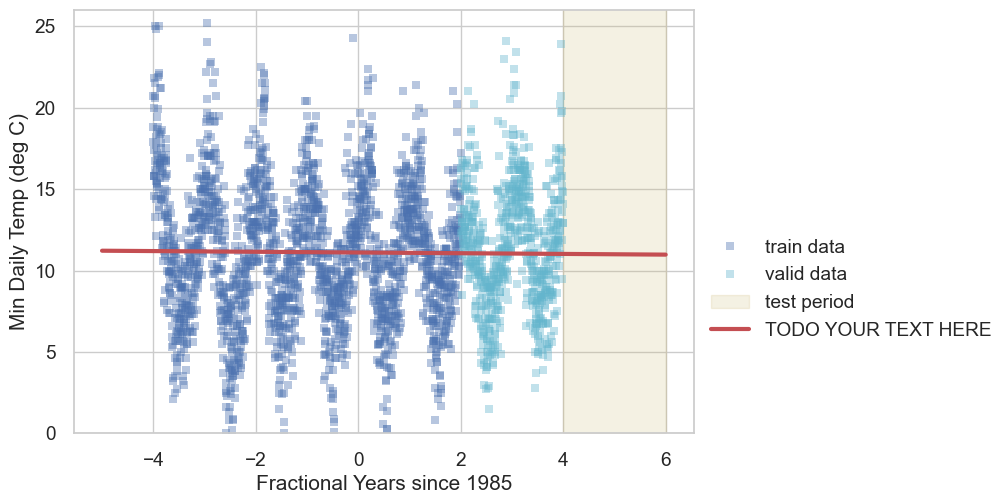

In [ ]:
plot_data_and_predictions(klr, 'TODO YOUR TEXT HERE')

# Problem 5: Squared Exponential Kernel Regression

In [ ]:
import sqexp_kernel
# Allow any simultaneous edits to sqexp_kernel.py
# to be reloaded again into this notebook when this cell is executed
importlib.reload(sqexp_kernel)

<module 'sqexp_kernel' from '/Users/mhughes/courses/cs135-23f-assignments/hw5/sqexp_kernel.py'>

### Establish a pipeline for SqExp Kernel Regression

Again, makes use of sklearn's `FunctionTransformer` (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)), which will apply our `calc_sqexp_kernel` kernel function as first 'transformation' step in our pipeline.

In [ ]:
sqexp_klr = sklearn.pipeline.Pipeline([
    ('sqexpKernelTransformer', 
        sklearn.preprocessing.FunctionTransformer(identity_kernel)), #TODO: use squared-exponential kernel
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

### Setup grid search for SqExp Kernel hyperparameters

In [ ]:
length_scale_grid = np.logspace(-2, 0, 9)
alpha_grid = np.logspace(-2, 3, 5)

print("Possible Values for sqexpKernelTransformer__kw_args['length_scale']")
for length_scale in length_scale_grid:
    print("% 11.3f" % length_scale)

print("Possible Values for ridgeRegressor__alpha")
for alpha in alpha_grid:
    print("% 11.3f" % alpha)

Possible Values for sqexpKernelTransformer__kw_args['length_scale']
      0.010
      0.018
      0.032
      0.056
      0.100
      0.178
      0.316
      0.562
      1.000
Possible Values for ridgeRegressor__alpha
      0.010
      0.178
      3.162
     56.234
   1000.000


In [ ]:
# Create dictionary where:
# each key is a pipeline parameter name
# each value is a grid of possible values
sqexp_param_grid_by_name = dict(
    sqexpKernelTransformer__kw_args=[dict(
        length_scale=ell,
        x_train_NF=x_trByYear_N1,
        ) for ell in length_scale_grid],
    ridgeRegressor__alpha=alpha_grid,
    )

In [ ]:
# Package up into a sklearn GridSearch object

sqexp_klr_grid_searcher = sklearn.model_selection.GridSearchCV(
    sqexp_klr,
    sqexp_param_grid_by_name,
    scoring='neg_mean_squared_error',
    cv=my_ByYear_splitter,
    return_train_score=True,
    refit=False)

### Run grid search: find hyperparameters that yield best heldout predictions

In [ ]:
start_time_sec = time.time()
sqexp_klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
sqexp_klr_search_results_df = pd.DataFrame(sqexp_klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    sqexp_klr_search_results_df.shape[0], elapsed_time_sec))

Grid search of  45 configurations done after    0.1 sec


In [ ]:
pd.set_option('display.precision', 4)
param_keys = ['param_ridgeRegressor__alpha', 'param_sqexpKernelTransformer__kw_args']
sqexp_klr_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

,param_ridgeRegressor__alpha,param_sqexpKernelTransformer__kw_args,mean_train_score,mean_test_score,rank_test_score,mean_fit_time
0,0.01,"{'length_scale': 0.01, 'x_train_NF': [[-4.0027...",-17.1946,-15.3344,37,0.0009
1,0.01,"{'length_scale': 0.01778279410038923, 'x_train...",-17.1946,-15.3344,37,0.0008
2,0.01,"{'length_scale': 0.03162277660168379, 'x_train...",-17.1946,-15.3344,37,0.0008
3,0.01,"{'length_scale': 0.05623413251903491, 'x_train...",-17.1946,-15.3344,37,0.0007
4,0.01,"{'length_scale': 0.1, 'x_train_NF': [[-4.00273...",-17.1946,-15.3344,37,0.0007
5,0.01,"{'length_scale': 0.1778279410038923, 'x_train_...",-17.1946,-15.3344,37,0.0007
6,0.01,"{'length_scale': 0.31622776601683794, 'x_train...",-17.1946,-15.3344,37,0.0007
7,0.01,"{'length_scale': 0.5623413251903491, 'x_train_...",-17.1946,-15.3344,37,0.0006
8,0.01,"{'length_scale': 1.0, 'x_train_NF': [[-4.00273...",-17.1946,-15.3344,37,0.0011
9,0.1778,"{'length_scale': 0.01, 'x_train_NF': [[-4.0027...",-17.1946,-15.3343,28,0.0007


### Determine the best hyperparameters

In [ ]:
best_row = sqexp_klr_search_results_df['rank_test_score'].argmin()
best_param_df_row = sqexp_klr_search_results_df.loc[best_row][param_keys]

# Remove the "param_" prefix
sqexp_best_params = best_param_df_row.to_dict()
for key in list(sqexp_best_params.keys()):
    sqexp_best_params[key.replace('param_', '')] = sqexp_best_params[key]
    del sqexp_best_params[key]

In [ ]:
print("Best Hyperparameters")
for k, v in sqexp_best_params.items():
    if isinstance(v, dict):
        for kk, vv in v.items():
            if kk.count('x_train'):
                continue
            print("%s %.5f" % (kk, vv))
    else:
        print("%s %.5f" % (k, v))

Best Hyperparameters
ridgeRegressor__alpha 1000.00000
length_scale 0.01000


In [ ]:
print("Best Results")
pd.DataFrame([sqexp_klr_search_results_df.loc[best_row, ['mean_train_score', 'mean_test_score', 'rank_test_score']]])

Best Results


,mean_train_score,mean_test_score,rank_test_score
36,-17.1966,-15.0929,1


### Refit model with best hyperparameters on ALL development data (train+valid)

In [ ]:
# TODO: call sqexp_klr.set_params(...) so that you are using the best hyperparameters found by grid search

In [ ]:
sqexp_klr.fit(x_all_ByYear_L1, y_all_ByYear_L);

### Make Figure 5: Predictions of sq-exp kernel

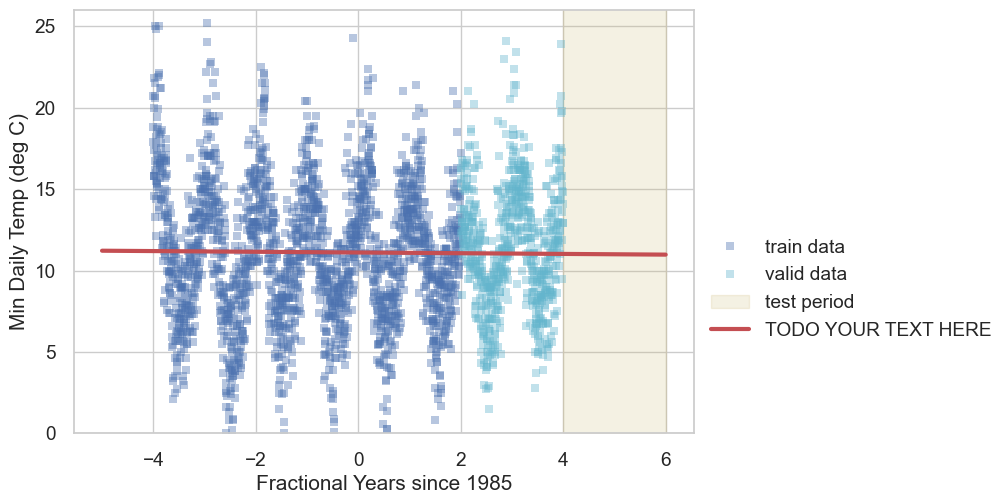

In [ ]:
plot_data_and_predictions(sqexp_klr, 'TODO YOUR TEXT HERE')

# Problem 6: Periodic kernel

In [ ]:
import periodic_kernel

# Allow any simultaneous edits to periodic_kernel.py
# to be reloaded again into this notebook when this cell is executed
importlib.reload(periodic_kernel)

<module 'periodic_kernel' from '/Users/mhughes/courses/cs135-23f-assignments/hw5/periodic_kernel.py'>

In [ ]:
periodic_klr = sklearn.pipeline.Pipeline([
    ('periodicKernelTransformer', 
         sklearn.preprocessing.FunctionTransformer(identity_kernel)), #TODO: use periodic kernel
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

### Setup grid search for periodic kernel

Don't need to change any values here!

In [ ]:
periodic_grid = [0.5, 1.0, 1.5, 2.0]
length_scale_grid = [0.01, 0.03, 0.09, 0.27]
alpha_grid = [1.0, 1000.0, 100000.0]

print("Possible Values for periodicKernelTransformer__kw_args['periodic']")
for period in periodic_grid:
    print("% 11.3f" % period)

print("Possible Values for periodicKernelTransformer__kw_args['length_scale']")
for length_scale in length_scale_grid:
    print("% 11.3f" % length_scale)

print("Possible Values for ridgeRegressor__alpha")
for alpha in alpha_grid:
    print("% 11.3f" % alpha)

Possible Values for periodicKernelTransformer__kw_args['periodic']
      0.500
      1.000
      1.500
      2.000
Possible Values for periodicKernelTransformer__kw_args['length_scale']
      0.010
      0.030
      0.090
      0.270
Possible Values for ridgeRegressor__alpha
      1.000
   1000.000
 100000.000


In [ ]:
periodic_param_grid_by_name = dict(
    periodicKernelTransformer__kw_args=[
        dict(length_scale=ell, period=p,
            x_train_NF=x_trByYear_N1) for (ell,p) in itertools.product(length_scale_grid, periodic_grid)],
    ridgeRegressor__alpha=alpha_grid,
    )

In [ ]:
periodic_klr_grid_searcher = sklearn.model_selection.GridSearchCV(
    periodic_klr,
    periodic_param_grid_by_name,
    scoring='neg_mean_squared_error',
    cv=my_ByYear_splitter,
    return_train_score=True,
    refit=False)

### Run grid search for 'period' and 'length_scale' and 'alpha' hyperparameters

In [ ]:
start_time_sec = time.time()
periodic_klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
periodic_klr_search_results_df = pd.DataFrame(periodic_klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    periodic_klr_search_results_df.shape[0], elapsed_time_sec))

Grid search of  48 configurations done after    0.1 sec


In [ ]:
pd.set_option('display.precision', 4)
param_keys = ['param_ridgeRegressor__alpha', 'param_periodicKernelTransformer__kw_args']
periodic_klr_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

,param_ridgeRegressor__alpha,param_periodicKernelTransformer__kw_args,mean_train_score,mean_test_score,rank_test_score,mean_fit_time
0,1.0,"{'length_scale': 0.01, 'period': 0.5, 'x_train...",-17.1946,-15.3341,33,0.0009
1,1000.0,"{'length_scale': 0.01, 'period': 0.5, 'x_train...",-17.1966,-15.0929,17,0.0008
2,100000.0,"{'length_scale': 0.01, 'period': 0.5, 'x_train...",-17.2955,-14.0894,1,0.0007
3,1.0,"{'length_scale': 0.01, 'period': 1.0, 'x_train...",-17.1946,-15.3341,33,0.0007
4,1000.0,"{'length_scale': 0.01, 'period': 1.0, 'x_train...",-17.1966,-15.0929,17,0.0007
5,100000.0,"{'length_scale': 0.01, 'period': 1.0, 'x_train...",-17.2955,-14.0894,1,0.0007
6,1.0,"{'length_scale': 0.01, 'period': 1.5, 'x_train...",-17.1946,-15.3341,33,0.0008
7,1000.0,"{'length_scale': 0.01, 'period': 1.5, 'x_train...",-17.1966,-15.0929,17,0.0008
8,100000.0,"{'length_scale': 0.01, 'period': 1.5, 'x_train...",-17.2955,-14.0894,1,0.0007
9,1.0,"{'length_scale': 0.01, 'period': 2.0, 'x_train...",-17.1946,-15.3341,33,0.0006


### Determine the best hyperparameters

In [ ]:
best_row = periodic_klr_search_results_df['rank_test_score'].argmin()
best_param_df_row = periodic_klr_search_results_df.loc[best_row][param_keys]

best_params = best_param_df_row.to_dict()
for key in list(best_params.keys()):
    best_params[key.replace('param_', '')] = best_params[key]
    del best_params[key]

In [ ]:
print("Best Hyperparameters")
for k, v in best_params.items():
    if isinstance(v, dict):
        for kk, vv in v.items():
            if kk.count('x_train'):
                continue
            print("%s['%s'] %.3f" % (k, kk, vv))
    else:
        print("%s %.3f" % (k, v))

Best Hyperparameters
ridgeRegressor__alpha 100000.000
periodicKernelTransformer__kw_args['length_scale'] 0.010
periodicKernelTransformer__kw_args['period'] 0.500


### Determine the performance results associated with these best hyperparameters

In [ ]:
print("Best Results")
pd.DataFrame([periodic_klr_search_results_df.loc[best_row, ['mean_train_score', 'mean_test_score', 'rank_test_score']]])

Best Results


,mean_train_score,mean_test_score,rank_test_score
2,-17.2955,-14.0894,1


### Retrain model with best hyperparameters on ALL development data

In [ ]:
# TODO: call periodic_klr.set_params(...) so that you are using the best hyperparameters found by grid search

In [ ]:
periodic_klr.fit(x_all_ByYear_L1, y_all_ByYear_L);

### Make Fig 6: Predictions of periodic kernel

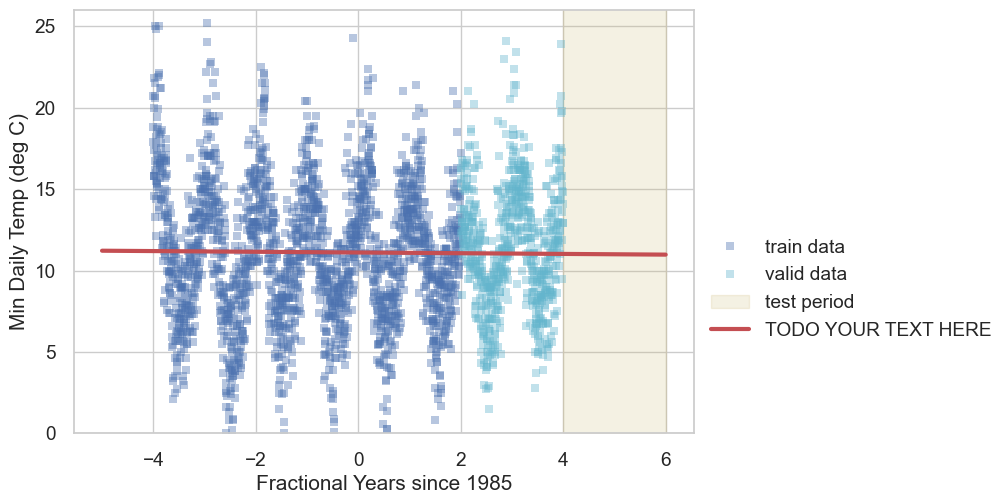

In [ ]:
plot_data_and_predictions(periodic_klr, 'TODO YOUR TEXT HERE')

# Problem 7

### Load test data

In [ ]:
data_te_df = pd.read_csv(os.path.join(DATA_DIR, 'data_test_ByYear.csv'))
x_te_T1 = data_te_df['years_since_19850101'].values[:][:,np.newaxis].copy()  # Load (T,1) feature values array
y_te_T = data_te_df['temp_deg_C'].values[:].copy()                           # Load (T,) feature values array

In [ ]:
row_dict_list = list()
for (split, x, y) in [
        ('train+valid', x_all_ByYear_L1, y_all_ByYear_L),
        ('test', x_te_T1, y_te_T)
        ]:
    for (method_name, predictor) in [
            ('linear kernel', klr),
            ('sqexp kernel', sqexp_klr),
            ('periodic kernel', periodic_klr),
            ]:

        yhat = predictor.predict(x)
        
        rmse = np.sqrt(np.mean(np.square(yhat - y)))
        row_dict = dict(method=method_name, rmse=rmse, split=split)
        row_dict_list.append(row_dict)

In [ ]:
df = pd.DataFrame(row_dict_list)

In [ ]:
df

,method,rmse,split
0,linear kernel,4.0596,train+valid
1,sqexp kernel,4.0596,train+valid
2,periodic kernel,4.0596,train+valid
3,linear kernel,4.1292,test
4,sqexp kernel,4.1292,test
5,periodic kernel,4.1292,test


## Create Table 7

In [ ]:
pd.set_option('display.precision', 2); # please report only 2 digits of precision after decimal for RMSE
tab_df = pd.pivot_table(df,
    values='rmse',
    index=['method'],
    columns=['split'],
    aggfunc=np.sum)\
    .reindex(['train+valid', 'test'], axis=1)\
    .reindex(['linear kernel', 'sqexp kernel', 'periodic kernel'])

In [ ]:
tab_df # Pretty print to this notebook

split,train+valid,test
method,,
linear kernel,4.06,4.13
sqexp kernel,4.06,4.13
periodic kernel,4.06,4.13
